# Coursera Capstone Notebook: Clustering of Rome Subway stations
## Introduction
The Rome Metro (Metropolitana di Roma) started operation in 1955. It has three lines: A (orange), B (blue) and C (green). It has 73 stations, the length of it is about 60 km. The lines A and B intersect at Termini Station, which is also the main train station in Rome. Annually it serves for 279 million of people (2012). We want to look at the areas surrounding metro stations and cluster them. The areas in the historical center of Rome have a lot of touristic attractions (Vatican, Colosseum, Trevi Fountain, Spanish Steps) and hotels. Some neighborhoods are in residential areas, other in commercial. The venues near to the station determine how people use it. Analysis of data can show the primary purpose of the station. This data is useful for commercial business (location to open a new business), for local government (can help them in city planning), and for subway development in the future (where open new stations).

In [2]:
import pandas as pd
import requests
!pip install folium
import folium # map rendering library
from bs4 import BeautifulSoup
import html5lib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data 

In [4]:
#get list of station from Wikipedia, create dataframe from it
#https://beenje.github.io/blog/posts/parsing-html-tables-in-python-with-pandas/
res = requests.get("https://it.wikipedia.org/wiki/Stazioni_della_metropolitana_di_Roma")
#if you don't have 'lxml' parser use default: 'html.parser'
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df_stations = pd.read_html(str(table), header=0)

#create dataframe
df_stations = df_stations[0]

#drop rows Borough == Not assigned
#df_stations = df_stations[df_stations.Borough != 'Not assigned']

# Select all duplicate rows based on Postal code
#duplicateRowsDF = df[df.duplicated(['Postal code'])]
#duplicateRowsDF

# replace / to ,
#df = df.replace(to_replace=r'\s/', value=',', regex=True)

#drop columns Interscambi and Note
df_stations.drop(columns=['Linea', 'Comune', 'Municipio', 'Interscambi', 'Note'], inplace=True)

#rename column titles to English
df_stations.rename(columns={"Stazione": "Station", "Data apertura": "Opened", "Tipologia": "Type"}, inplace=True)

#save dataframe to csv file for easy access
df_stations.to_csv('Stations_wiki.csv')

df_stations.head(5)

,Station,Opened,Type
0,Alessandrino,9 novembre 2014,sotterranea
1,Anagnina,11 giugno 1980,sotterranea
2,Arco di Travertino,16 febbraio 1980,sotterranea
3,Baldo degli Ubaldi,1º gennaio 2000,sotterranea
4,Barberini - Fontana di Trevi,16 febbraio 1980,sotterranea


In [8]:
#read our saved csv file and convert it to dataframe
df_stations=pd.read_csv("https://raw.githubusercontent.com/riccione/Coursera_Capstone/master/Stations_wiki.csv",index_col=0)
df_stations.head()

,Station,Opened,Type
0,Alessandrino,9 novembre 2014,sotterranea
1,Anagnina,11 giugno 1980,sotterranea
2,Arco di Travertino,16 febbraio 1980,sotterranea
3,Baldo degli Ubaldi,1º gennaio 2000,sotterranea
4,Barberini - Fontana di Trevi,16 febbraio 1980,sotterranea


In [10]:

#remove day and month from Open Date
df_stations.replace({'Opened': r'^[0-9]+\º*\s[a-z]+\s'}, {'Opened': ''}, regex=True, inplace=True)

#clean some dates
df_stations.replace({'Opened': r'\[1\]'}, {'Opened': ''}, regex=True, inplace=True)
df_stations.replace({'Opened': '1980 (MA)12 maggio 2018 (MC)'}, '1980', inplace=True)
df_stations.replace({'Opened': '1955 (MB)16 febbraio 1980 (MA)'}, '1955', inplace=True)
df_stations.replace({'Station': r'Manzoni\s.*'}, {'Station': 'Manzoni'}, regex=True, inplace=True)
df_stations.replace({'Station': r'Furio\sCamillo.*'}, {'Station': 'Furio Camillo'}, regex=True, inplace=True)
df_stations.replace({'Station': r'Colli\sAlbani.*'}, {'Station': 'Colli Albani'}, regex=True, inplace=True)
df_stations.replace({'Station': r'Porta\sFurba.*'}, {'Station': 'Porta Furba - Quadraro'}, regex=True, inplace=True)
df_stations.replace({'Station': r'Sant\'Agnese\/Annibaliano'}, {'Station': 'Sant Agnese - Annibaliano'}, regex=True, inplace=True)

#translate types of stations
df_stations.replace({'Type': 'sotterranea'}, 'underground', inplace=True)
df_stations.replace({'Type': 'in superficie'}, 'surface', inplace=True)
df_stations.replace({'Type': 'in galleria artificiale'}, 'in artificial gallery', inplace=True)
df_stations.replace({'Type': 'sopraelevata'}, 'overground', inplace=True)

df_stations.head(5)

,Station,Opened,Type
0,Alessandrino,2014,underground
1,Anagnina,1980,underground
2,Arco di Travertino,1980,underground
3,Baldo degli Ubaldi,2000,underground
4,Barberini - Fontana di Trevi,1980,underground


In [12]:
df_stations.shape

(73, 3)

In [14]:
#csv = df_stations.to_csv(index=False)
#print(csv)

In [16]:
#get geo data for Rome subway station
file = 'Rome_Metro.csv'
df_geo = pd.read_csv('https://raw.githubusercontent.com/riccione/Coursera_Capstone/master/Rome_Metro.csv',sep=",")
df_geo.columns = ['Station', 'Opened', 'Line', 'Latitude', 'Longitude']
#drop columns Opened
df_geo.drop(columns=['Opened'], inplace=True)
df_geo.head(5)

,Station,Line,Latitude,Longitude
0,Battistini,A,41.906461,12.414722
1,Cornelia,A,41.902222,12.425278
2,Baldo degli Ubaldi,A,41.898889,12.432778
3,Valle Aurelia,A,41.903056,12.441667
4,Cipro,A,41.907500,12.447500


In [18]:
#sort dataframe
df_geo.sort_values(by=['Station'], inplace=True)
df_geo.reset_index(drop=True, inplace=True)
df_geo.head(5)

,Station,Line,Latitude,Longitude
0,Alessandrino,C,41.871349,12.578701
1,Anagnina,A,41.842778,12.586111
2,Arco di Travertino,A,41.866705,12.535070
3,Baldo degli Ubaldi,A,41.898889,12.432778
4,Barberini - Fontana di Trevi,A,41.903889,12.488889


In [20]:
index = 0
for t in df_geo.duplicated('Station'):
        if (t):
            print(index, t)
        index += 1

59 True
66 True


In [21]:

#rename Basilica S. Paolo to Basilica San Paolo
df_geo.replace({'Station': 'Basilica S. Paolo'}, 'Basilica San Paolo', inplace=True)
#rename Manzoni – Museo della Liberazione to Manzoni
df_geo.replace({'Station': r'Manzoni\s.*'}, {'Station': 'Manzoni'}, regex=True, inplace=True)
df_geo.replace({'Station': r'Ponte\sLungo.*'}, {'Station': 'Ponte Lungo'}, regex=True, inplace=True)
df_geo.replace({'Station': r'Furio\sCamillo.*'}, {'Station': 'Furio Camillo'}, regex=True, inplace=True)
df_geo.replace({'Station': r'Colli\sAlbani.*'}, {'Station': 'Colli Albani'}, regex=True, inplace=True)
df_geo.replace({'Station': r'Numidio\sQuadrato.*'}, {'Station': 'Numidio Quadrato'}, regex=True, inplace=True)
df_geo.replace({'Station': r'Lucio\sSestio.*'}, {'Station': 'Lucio Sestio'}, regex=True, inplace=True)
df_geo.replace({'Station': r'Sant\'Agnese\s.\sAnnibaliano'}, {'Station': 'Sant Agnese - Annibaliano'}, regex=True, inplace=True)
df_geo[50:70]
#df_stations[20:30]

,Station,Line,Latitude,Longitude
50,Policlinico,B,41.908889,12.511667
51,Ponte Lungo,A,41.877845,12.518957
52,Ponte Mammolo,B,41.920556,12.565000
53,Porta Furba - Quadraro,A,41.863790,12.548206
54,Quintiliani,B,41.915556,12.538611
55,Re di Roma,A,41.881635,12.514405
56,Rebibbia,B,41.925833,12.573056
57,Repubblica - Teatro dell'Opera,A,41.902500,12.495556
58,San Giovanni,C,41.885278,12.509444
59,San Giovanni,A,41.885278,12.509444


In [23]:
#remove San Giovanni and Termini, basically they are not duplicates
#these stations duplicates, because they exist on the crossing of two lines: San Giovanni A and C; Termini A and B. 
#The exits to different lines were build in different periods of time, however it is not important for our study.
df_geo[df_geo['Station'] == "San Giovanni"]

,Station,Line,Latitude,Longitude
58,San Giovanni,C,41.885278,12.509444
59,San Giovanni,A,41.885278,12.509444


In [25]:
df_geo.iat[58,1] = 'AC'
counter = len(df_geo[df_geo['Station'] == "San Giovanni"])
if (counter > 1):
    df_geo.drop(df_geo.index[59], inplace=True)
df_geo[df_geo['Station'] == "San Giovanni"]

,Station,Line,Latitude,Longitude
58,San Giovanni,AC,41.885278,12.509444


In [27]:
df_geo.reset_index(drop=True, inplace=True)
df_geo[df_geo['Station'] == 'Termini']

,Station,Line,Latitude,Longitude
64,Termini,B,41.901542,12.500596
65,Termini,A,41.901542,12.500596


In [29]:
df_geo.iat[64,1] = 'AB'
counter = len(df_geo[df_geo['Station'] == "Termini"])
print(counter)
if (counter > 1):
    df_geo.drop(df_geo.index[65], inplace=True)
df_geo[df_geo['Station'] == "Termini"]

1


,Station,Line,Latitude,Longitude
64,Termini,AB,41.901542,12.500596


In [31]:
df_geo.shape

(73, 4)

In [34]:
df_geo['Station'].value_counts()

Parco di Centocelle               1
Baldo degli Ubaldi                1
Bolognetta                        1
Torre Gaia                        1
Torre Angela                      1
                                 ..
Jonio                             1
Giulio Agricola                   1
Repubblica - Teatro dell'Opera    1
Piramide                          1
Policlinico                       1
Name: Station, Length: 73, dtype: int64

In [36]:
df = df_stations.merge(df_geo, on="Station", how = 'inner')
df[20:30]

,Station,Opened,Type,Line,Latitude,Longitude
20,EUR Fermi,1955,in artificial gallery,B,41.828611,12.471111
21,EUR Magliana,1955,surface,B,41.839444,12.463333
22,EUR Palasport,1955,in artificial gallery,B,41.830000,12.466667
23,Finocchio,2014,underground,C,41.865482,12.687809
24,Flaminio - Piazza del Popolo,1980,underground,A,41.911944,12.475833
25,Furio Camillo,1980,underground,A,41.874722,12.523056
26,Garbatella,1990,surface,B,41.866667,12.483333
27,Gardenie,2015,underground,C,41.886300,12.561700
28,Giardinetti,2014,in trincea,C,41.864275,12.610113
29,Giulio Agricola,1980,underground,A,41.856598,12.562633


In [38]:
df.shape

(73, 6)

In [40]:
line_a = df[df['Line']=='A']
line_ab = df[df['Line']=='AB']
line_ac = df[df['Line']=='AC']
line_a = line_a.append(line_ab)
line_a = line_a.append(line_ac)
line_a

,Station,Opened,Type,Line,Latitude,Longitude
1,Anagnina,1980,underground,A,41.842778,12.586111
2,Arco di Travertino,1980,underground,A,41.866705,12.535070
3,Baldo degli Ubaldi,2000,underground,A,41.898889,12.432778
4,Barberini - Fontana di Trevi,1980,underground,A,41.903889,12.488889
6,Battistini,2000,underground,A,41.906461,12.414722
12,Cinecittà,1980,underground,A,41.849300,12.574377
13,Cipro,1999,underground,A,41.907500,12.447500
15,Colli Albani,1980,underground,A,41.869400,12.530100
18,Cornelia,2000,underground,A,41.902222,12.425278
24,Flaminio - Piazza del Popolo,1980,underground,A,41.911944,12.475833


In [42]:
#reorder line_a stations in a right order
line_a = line_a.reindex([6,18,3,71,13,45,34,24,61,4,57,64,72,39,58,55,51,25,15,2,53,44,37,29,62,12,1])
line_a

,Station,Opened,Type,Line,Latitude,Longitude
6,Battistini,2000,underground,A,41.906461,12.414722
18,Cornelia,2000,underground,A,41.902222,12.425278
3,Baldo degli Ubaldi,2000,underground,A,41.898889,12.432778
71,Valle Aurelia,1999,underground,A,41.903056,12.441667
13,Cipro,1999,underground,A,41.907500,12.447500
45,Ottaviano - San Pietro - Musei Vaticani,1980,underground,A,41.909444,12.458056
34,Lepanto,1980,underground,A,41.911389,12.466111
24,Flaminio - Piazza del Popolo,1980,underground,A,41.911944,12.475833
61,Spagna,1980,underground,A,41.906500,12.483056
4,Barberini - Fontana di Trevi,1980,underground,A,41.903889,12.488889


In [44]:
line_b = df[df['Line']=='B']
line_b = line_b.append(line_ab)
line_b_left = line_b[line_b['Station'] != 'Rebibbia']
line_b_left = line_b[line_b['Station'] != 'Ponte Mammolo']
line_b_left = line_b[line_b['Station'] != 'Pietralata']
line_b_left = line_b[line_b['Station'] != 'Monti Tiburtini']
line_b_left = line_b[line_b['Station'] != 'Quintiliani']
line_b_left = line_b[line_b['Station'] != 'Tiburtina']
line_b_left

,Station,Opened,Type,Line,Latitude,Longitude
5,Basilica San Paolo,1955,overground,B,41.856111,12.478194
7,Bologna,1990,underground,B,41.913333,12.520556
10,Castro Pretorio,1990,underground,B,41.906111,12.505556
11,Cavour,1955,underground,B,41.895000,12.493611
14,Circo Massimo,1955,underground,B,41.883611,12.488056
16,Colosseo,1955,underground,B,41.891389,12.491389
17,Conca d'Oro,2012,underground,B,41.939444,12.527778
20,EUR Fermi,1955,in artificial gallery,B,41.828611,12.471111
21,EUR Magliana,1955,surface,B,41.839444,12.463333
22,EUR Palasport,1955,in artificial gallery,B,41.830000,12.466667


In [46]:
#reorder line_a stations in a right order
line_b_left = line_b_left.reindex([32,17,35,60,7,50,10,64,11,16,14,49,26,5,40,21,22,20,33])
line_b_left

,Station,Opened,Type,Line,Latitude,Longitude
32,Jonio,2015,underground,B,41.946389,12.528056
17,Conca d'Oro,2012,underground,B,41.939444,12.527778
35,Libia,2012,underground,B,41.932778,12.520556
60,Sant Agnese - Annibaliano,2012,underground,B,41.923889,12.515833
7,Bologna,1990,underground,B,41.913333,12.520556
50,Policlinico,1990,underground,B,41.908889,12.511667
10,Castro Pretorio,1990,underground,B,41.906111,12.505556
64,Termini,1955,underground,AB,41.901542,12.500596
11,Cavour,1955,underground,B,41.895000,12.493611
16,Colosseo,1955,underground,B,41.891389,12.491389


In [48]:
def remove_stations_from_line(dataset, station_list):
    for station in station_list:
        dataset = dataset[dataset['Station'] != station]
    return dataset

In [50]:
line_b_right = remove_stations_from_line(line_b,['Jonio','Conca d\'Oro','Libia','Sant Agnese - Annibaliano','Policlinico','Castro Pretorio',
                                                 'Termini','Cavour','Colosseo','Circo Massimo','Piramide','Garbatella','Basilica San Paolo',
                                                 'Marconi','EUR Magliana','EUR Palasport','EUR Fermi','Laurentina'])
line_b_right

,Station,Opened,Type,Line,Latitude,Longitude
7,Bologna,1990,underground,B,41.913333,12.520556
43,Monti Tiburtini,1990,underground,B,41.915833,12.547778
47,Pietralata,1990,underground,B,41.914722,12.555000
52,Ponte Mammolo,1995,overground,B,41.920556,12.565000
54,Quintiliani,2003,underground,B,41.915556,12.538611
56,Rebibbia,1990,underground,B,41.925833,12.573056
59,Santa Maria del Soccorso,1990,underground,B,41.915556,12.560833
65,Tiburtina,1990,underground,B,41.910833,12.529444


In [52]:
#reorder line_a stations in a right order
line_b_right = line_b_right.reindex([56,52,59,47,43,54,65,7])
line_b_right

,Station,Opened,Type,Line,Latitude,Longitude
56,Rebibbia,1990,underground,B,41.925833,12.573056
52,Ponte Mammolo,1995,overground,B,41.920556,12.565000
59,Santa Maria del Soccorso,1990,underground,B,41.915556,12.560833
47,Pietralata,1990,underground,B,41.914722,12.555000
43,Monti Tiburtini,1990,underground,B,41.915833,12.547778
54,Quintiliani,2003,underground,B,41.915556,12.538611
65,Tiburtina,1990,underground,B,41.910833,12.529444
7,Bologna,1990,underground,B,41.913333,12.520556


In [55]:
line_c = df[df['Line']=='C']
line_c = line_c.append(line_ac)
line_c

,Station,Opened,Type,Line,Latitude,Longitude
0,Alessandrino,2014,underground,C,41.871349,12.578701
8,Bolognetta,2014,overground,C,41.865134,12.680883
9,Borghesiana,2014,in trincea,C,41.864707,12.667300
19,Due Leoni-Fontana Candida,2014,surface,C,41.864907,12.658093
23,Finocchio,2014,underground,C,41.865482,12.687809
27,Gardenie,2015,underground,C,41.886300,12.561700
28,Giardinetti,2014,in trincea,C,41.864275,12.610113
30,Graniti,2014,surface,C,41.865690,12.698020
31,Grotte Celoni,2014,surface,C,41.862666,12.646096
36,Lodi,2015,underground,C,41.886732,12.517762


In [57]:
#reorder line_a stations in a right order
line_c = line_c.reindex([58,36,48,38,63,27,41,46,0,69,68,28,70,66,67,31,19,9,8,23,30,42])
line_c

,Station,Opened,Type,Line,Latitude,Longitude
58,San Giovanni,1980,underground,AC,41.885278,12.509444
36,Lodi,2015,underground,C,41.886732,12.517762
48,Pigneto,2015,underground,C,41.888456,12.528178
38,Malatesta,2015,underground,C,41.887300,12.540200
63,Teano,2015,underground,C,41.889230,12.551311
27,Gardenie,2015,underground,C,41.886300,12.561700
41,Mirti,2015,underground,C,41.881100,12.566600
46,Parco di Centocelle,2014,underground,C,41.874619,12.568030
0,Alessandrino,2014,underground,C,41.871349,12.578701
69,Torre Spaccata,2014,underground,C,41.869000,12.586600


In [59]:
#lets get the point of city center: Barberini - Fontana di Trevi
latitude = df.loc[4,'Latitude']
longitude = df.loc[4, 'Longitude']

print(latitude)
print(longitude)
type(latitude)
type(longitude)

41.903889
12.488889


numpy.float64

In [61]:
rome_lat_long = [latitude, longitude]

# create map of Toronto using latitude and longitude values
rome_map = folium.Map(location=rome_lat_long, zoom_start=12)

#colors for markers
color_A = '#FFA500' #official color is orange
color_B = '#0000FF' #official color is blue
color_C = '#008000' #official color is green
color_other = '#FF0000'

#create empty list
lines=[]

#add markers to map
for lat, lng, label, line in zip(df['Latitude'],df['Longitude'],df['Station'],df['Line']):
    label = folium.Popup(label, parse_html=True)
    if(line=='A'):
        color_marker=color_A
    elif(line=='B'):
        color_marker=color_B
    elif(line=='C'):
        color_marker=color_C
    else:
        color_marker=color_other
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color_marker,
        fill=True,
        fill_color=color_marker,
        fill_opacity=0.75,
        parse_html=False).add_to(rome_map)
    
#draw lines function
def draw_lines(dataset):
    lines=[]
    for lat, lng in zip(dataset['Latitude'],dataset['Longitude']):
        lines.append(tuple([lat, lng]))
    return lines
        
#add lines A
folium.PolyLine(draw_lines(line_a), color=color_A, weight=2.5, opacity=1).add_to(rome_map)   
#add lines B left
folium.PolyLine(draw_lines(line_b_left), color=color_B, weight=2.5, opacity=1).add_to(rome_map)   
#add lines B right
folium.PolyLine(draw_lines(line_b_right), color=color_B, weight=2.5, opacity=1).add_to(rome_map)
#add lines C right
folium.PolyLine(draw_lines(line_c), color=color_C, weight=2.5, opacity=1).add_to(rome_map)

rome_map

In [63]:
rome_map.save('Rome_map.html')

In [65]:
#save dataset to csv file
df.to_csv('Stations.csv')

# Four square

In [67]:
LIMIT = 100
radius = 1000

In [69]:
# @hidden_cell
CLIENT_ID = 'VWVNFIXR5UTHPLMEIURLBV00IS1RKIMOFLSEYIMZI0KBN0XH'
CLIENT_SECRET = 'P3C2GAFNYNEQYSOTMY52SNJW2JRCGPTCEP3PBNHIPJIEP4LE'
VERSION = '20200425'

## Analysis of venues categories

In [71]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [73]:
len(results['response']['categories'])

10

In [75]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))

print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


## Query number of venues in each category

In [77]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
def get_venues_count(latitude, longitude, radius, categoryId):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                latitude, 
                longitude,
                radius,
                categoryId)

    # make the GET request
    results = requests.get(url).json()
    return results['response']['totalResults']

In [79]:
#Create new dataframe to store venues data
stations_venues_df = df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0
stations_venues_df.head()

,Station,Opened,Type,Line,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Alessandrino,2014,underground,C,41.871349,12.578701,0,0,0,0,0,0,0,0,0,0
1,Anagnina,1980,underground,A,41.842778,12.586111,0,0,0,0,0,0,0,0,0,0
2,Arco di Travertino,1980,underground,A,41.866705,12.535070,0,0,0,0,0,0,0,0,0,0
3,Baldo degli Ubaldi,2000,underground,A,41.898889,12.432778,0,0,0,0,0,0,0,0,0,0
4,Barberini - Fontana di Trevi,1980,underground,A,41.903889,12.488889,0,0,0,0,0,0,0,0,0,0


In [ ]:
#SKIP - use too many request for sandbox
#Request number of venues
#for station, lat, lng in zip(df['Station'],df['Latitude'],df['Longitude']):
for i, row in stations_venues_df.iterrows():
    print(i)
    for c in categories_list:
        stations_venues_df.loc[i, c[0]] = get_venues_count(row.Latitude,row.Longitude, radius=1000, categoryId=c[1])
    stations_venues_df.to_csv('Stations_venues.csv')

In [82]:
stations_venues_df = pd.read_csv('Stations_venues.csv', index_col=0)
stations_venues_df.head()

,Station,Opened,Type,Line,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Alessandrino,2014,underground,C,41.871349,12.578701,4,7,1,7,6,8,6,3,13,5
1,Anagnina,1980,underground,A,41.842778,12.586111,3,3,0,9,4,1,3,0,12,10
2,Arco di Travertino,1980,underground,A,41.866705,12.535070,0,0,0,0,0,0,0,0,0,0
3,Baldo degli Ubaldi,2000,underground,A,41.898889,12.432778,0,0,0,0,0,0,0,0,0,0
4,Barberini - Fontana di Trevi,1980,underground,A,41.903889,12.488889,0,0,0,0,0,0,0,0,0,0


### Visualize data

In [83]:

stations_venues_df[['Arts & Entertainment','College & University','Event','Food','Nightlife Spot','Outdoors & Recreation','Professional & Other Places','Residence','Shop & Service','Travel & Transport']].describe()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,0.095890,0.136986,0.013699,0.219178,0.136986,0.123288,0.123288,0.041096,0.342466,0.205479
std,0.581291,0.886865,0.117041,1.325462,0.838568,0.942001,0.780762,0.351123,2.056286,1.301270
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,7.000000,1.000000,9.000000,6.000000,8.000000,6.000000,3.000000,13.000000,10.000000


In [85]:
tmp_df = stations_venues_df[['Arts & Entertainment','College & University','Event','Food','Nightlife Spot','Outdoors & Recreation','Professional & Other Places','Residence','Shop & Service','Travel & Transport']]
tmp_df.head(3)

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,4,7,1,7,6,8,6,3,13,5
1,3,3,0,9,4,1,3,0,12,10
2,0,0,0,0,0,0,0,0,0,0


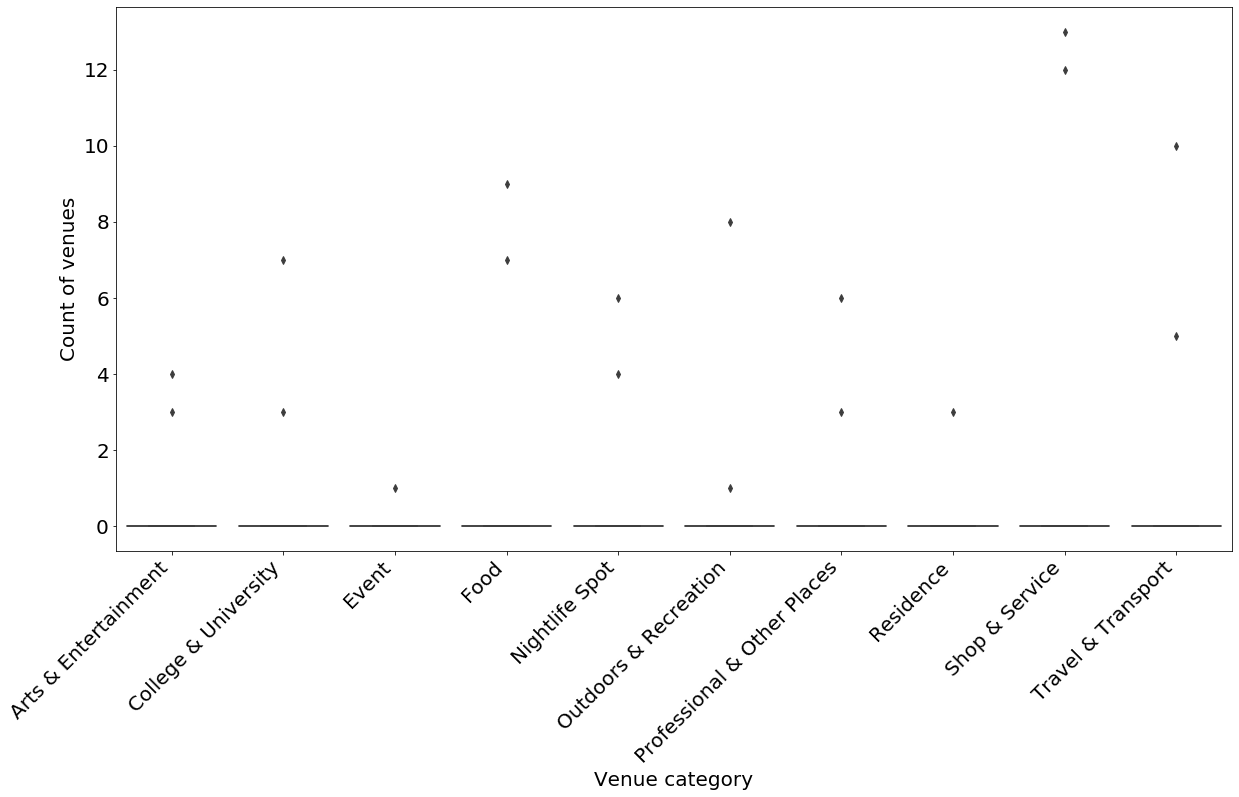

In [87]:
import seaborn as sns
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = tmp_df)
#ax = sns.swarmplot(data=tmp_df, color="black", edgecolor="gray")
ax.set_ylabel('Count of venues', fontsize=20)
ax.set_xlabel('Venue category', fontsize=20)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [89]:
if 'Event' in tmp_df.columns:
    tmp_df.drop(columns=['Event', 'Residence'], inplace=True)
    stations_venues_df.drop(columns=['Event', 'Residence'], inplace=True)
    categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))
    categories_list = list(filter(lambda x: x[0] != 'Residence', categories_list))

In [91]:

#normalize data
from sklearn.preprocessing import MinMaxScaler

X = tmp_df.values
cluster_dataset = MinMaxScaler().fit_transform(X)

In [96]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,1.00,1.000000,0.777778,1.000000,1.000,1.0,1.000000,0.5
1,0.75,0.428571,1.000000,0.666667,0.125,0.5,0.923077,1.0
2,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
3,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
4,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0


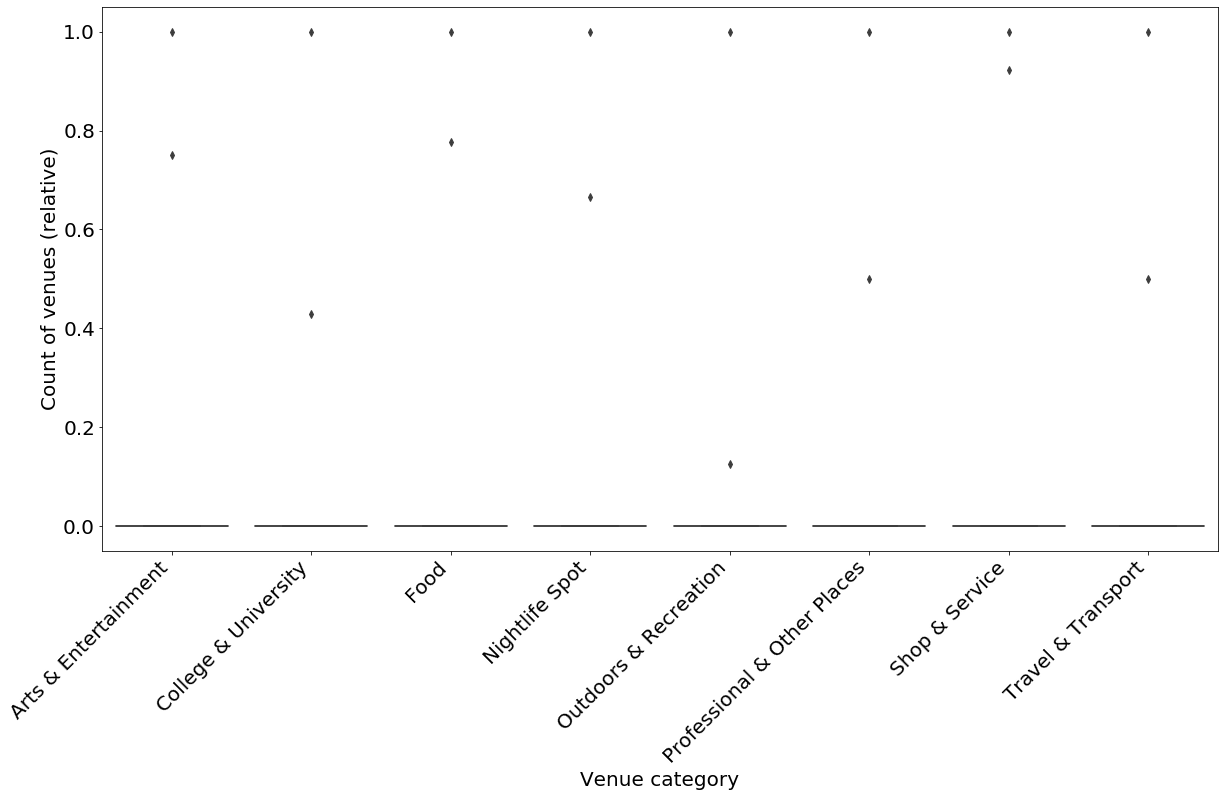

In [99]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=20)
ax.set_xlabel('Venue category', fontsize=20)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [101]:
# Clustering of the Data frame
cluster_df.head() 

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,1.00,1.000000,0.777778,1.000000,1.000,1.0,1.000000,0.5
1,0.75,0.428571,1.000000,0.666667,0.125,0.5,0.923077,1.0
2,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
3,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
4,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0


C:\Users\Renoir123\anaconda3\lib\site-packages\ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
C:\Users\Renoir123\anaconda3\lib\site-packages\ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
C:\Users\Renoir123\anaconda3\lib\site-packages\ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
C:\Users\Renoir123\anaconda3\lib\site-packages\ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
C:\Users\Renoir123\anaconda3\lib\site-packages\i

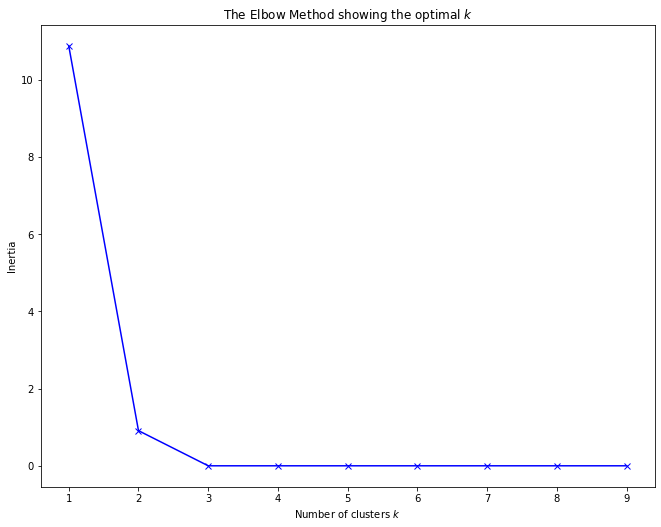

In [103]:
from sklearn.cluster import KMeans
wss = []
for i in range(1,10):
    fitx = KMeans(n_clusters=i).fit(cluster_df)
    wss.append(fitx.inertia_)

plt.figure(figsize=(11,8.5))
plt.plot(range(1,10), wss, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

### So, optimal number of clusters based on 'Elbow method' is 3 for our dataframe. Note that, the elbow method is sometimes ambiguous. An alternative is the average silhouette method (Kaufman and Rousseeuw, 1990) which can be also used with any clustering approach. Let's try to use different approach to find optimal number of clusters - Silhouette method. The Silhouette Score reaches its global maximum at the optimal k.

C:\Users\Renoir123\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  
C:\Users\Renoir123\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  
C:\Users\Renoir123\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  
C:\Users\Renoir123\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  
C:\Users\Renoir123\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X

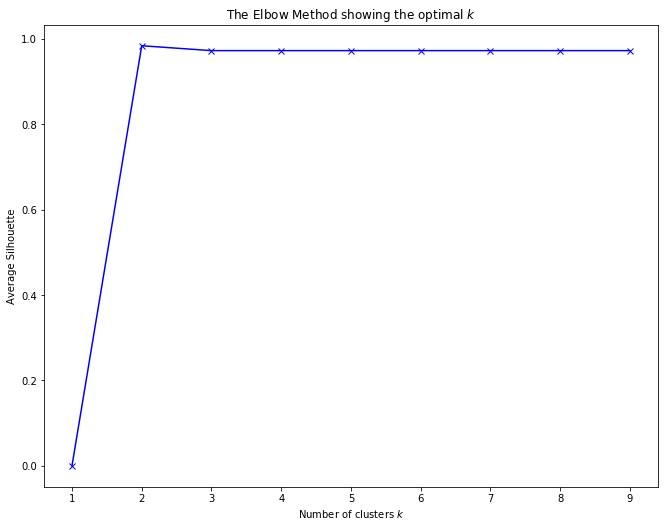

In [105]:
import numpy as np
from sklearn.metrics import silhouette_score

scores = [0]
for i in range(2,10):
    fitx = KMeans(n_clusters=i).fit(cluster_df)
    score = silhouette_score(cluster_df, fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,10), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()


The Silhouette method shows, that 2 is optimal choice for number of clusters. However observation and analysis showed that 2 is not enough, so we are going to use value - 3.

In [106]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
cluster_labels = 'Cluster Labels'
if cluster_labels in cluster_df:
    cluster_df.drop(columns=[cluster_labels],inplace=True)
    
cluster_df.insert(0, cluster_labels, kmeans.labels_)

cluster_df.head(5)

,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,1,1.00,1.000000,0.777778,1.000000,1.000,1.0,1.000000,0.5
1,2,0.75,0.428571,1.000000,0.666667,0.125,0.5,0.923077,1.0
2,0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
3,0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
4,0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0


In [108]:
clustered_df = pd.merge(df, cluster_df, right_index=True, left_index=True)
clustered_df.head(5)

,Station,Opened,Type,Line,Latitude,Longitude,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Alessandrino,2014,underground,C,41.871349,12.578701,1,1.00,1.000000,0.777778,1.000000,1.000,1.0,1.000000,0.5
1,Anagnina,1980,underground,A,41.842778,12.586111,2,0.75,0.428571,1.000000,0.666667,0.125,0.5,0.923077,1.0
2,Arco di Travertino,1980,underground,A,41.866705,12.535070,0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
3,Baldo degli Ubaldi,2000,underground,A,41.898889,12.432778,0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
4,Barberini - Fontana di Trevi,1980,underground,A,41.903889,12.488889,0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0


In [110]:
clustered_df_boxplot=clustered_df[['Cluster Labels','Arts & Entertainment','College & University','Food','Nightlife Spot','Outdoors & Recreation','Professional & Other Places','Shop & Service','Travel & Transport']]

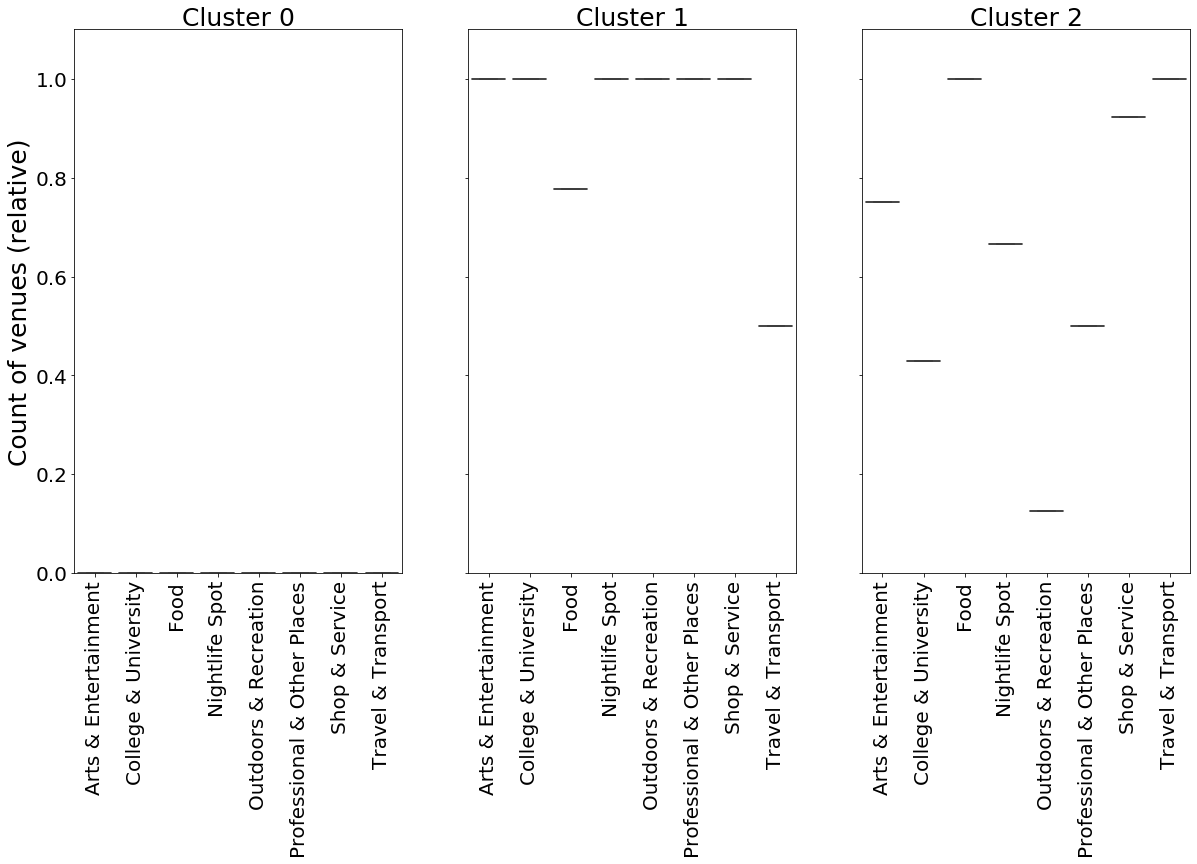

In [113]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)
axes[0].set_ylabel('Count of venues (relative)', fontsize=25)

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    #sns.boxplot(data = clustered_df[clustered_df['Cluster Labels']==k].drop('Cluster Labels',1), ax=axes[k])
    sns.boxplot(data = clustered_df_boxplot[clustered_df_boxplot['Cluster Labels']==k].drop('Cluster Labels',1), ax=axes[k])

plt.show()

In [115]:
#create map of Rome with all stations
map_rome_metro = folium.Map(location=[latitude, longitude], zoom_start=12)

#add markers
for i, station, latitude, longitude, cluster in zip(clustered_df.index,
                                         clustered_df['Station'],
                                         clustered_df['Latitude'],
                                         clustered_df['Longitude'],
                                         clustered_df['Cluster Labels']):
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','orange','red']
    #Calculate top 3 categories for each station
    station_series = clustered_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker(
        [latitude,longitude],
        fill=True,
        fill_opacity=0.5,
        popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster]
    ).add_to(map_rome_metro)
    
#add lines A
folium.PolyLine(draw_lines(line_a), color=color_A, weight=2.5, opacity=1).add_to(map_rome_metro)   
#add lines B left
folium.PolyLine(draw_lines(line_b_left), color=color_B, weight=2.5, opacity=1).add_to(map_rome_metro)   
#add lines B right
folium.PolyLine(draw_lines(line_b_right), color=color_B, weight=2.5, opacity=1).add_to(map_rome_metro)
#add lines C right
folium.PolyLine(draw_lines(line_c), color=color_C, weight=2.5, opacity=1).add_to(map_rome_metro)    
map_rome_metro

In [117]:
clustered_df.head(5)

,Station,Opened,Type,Line,Latitude,Longitude,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Alessandrino,2014,underground,C,41.871349,12.578701,1,1.00,1.000000,0.777778,1.000000,1.000,1.0,1.000000,0.5
1,Anagnina,1980,underground,A,41.842778,12.586111,2,0.75,0.428571,1.000000,0.666667,0.125,0.5,0.923077,1.0
2,Arco di Travertino,1980,underground,A,41.866705,12.535070,0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
3,Baldo degli Ubaldi,2000,underground,A,41.898889,12.432778,0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0
4,Barberini - Fontana di Trevi,1980,underground,A,41.903889,12.488889,0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.0


In [120]:
#get top 3 categories for a station
def getTopCategories(dataset):
    c=['Max1','Max2','Max3']
    dataset_max=(dataset[['Arts & Entertainment','College & University','Food','Nightlife Spot','Outdoors & Recreation','Professional & Other Places','Shop & Service','Travel & Transport']]
                     .apply(lambda x: pd.Series(x.nlargest(3).index,index=c),axis=1))
    dataset_max = pd.merge(dataset[['Station']], dataset_max,right_index=True, left_index=True)
    return dataset_max

In [122]:
# Cluster 1
cluster1_df = clustered_df.loc[clustered_df['Cluster Labels'] == 0, clustered_df.columns[[0] + list(range(5, clustered_df.shape[1]))]]
cluster1_df

,Station,Longitude,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
2,Arco di Travertino,12.535070,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Baldo degli Ubaldi,12.432778,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Barberini - Fontana di Trevi,12.488889,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Basilica San Paolo,12.478194,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Battistini,12.414722,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
68,Torre Maura,12.596878,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,Torre Spaccata,12.586600,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,Torrenova,12.616840,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,Valle Aurelia,12.441667,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
getTopCategories(cluster1_df)

,Station,Max1,Max2,Max3
2,Arco di Travertino,Arts & Entertainment,College & University,Food
3,Baldo degli Ubaldi,Arts & Entertainment,College & University,Food
4,Barberini - Fontana di Trevi,Arts & Entertainment,College & University,Food
5,Basilica San Paolo,Arts & Entertainment,College & University,Food
6,Battistini,Arts & Entertainment,College & University,Food
...,...,...,...,...
68,Torre Maura,Arts & Entertainment,College & University,Food
69,Torre Spaccata,Arts & Entertainment,College & University,Food
70,Torrenova,Arts & Entertainment,College & University,Food
71,Valle Aurelia,Arts & Entertainment,College & University,Food


In [126]:
# Cluster 2
cluster2_df=clustered_df.loc[clustered_df['Cluster Labels'] == 1, clustered_df.columns[[0] + list(range(5, clustered_df.shape[1]))]]
cluster2_df

,Station,Longitude,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Alessandrino,12.578701,1,1.0,1.0,0.777778,1.0,1.0,1.0,1.0,0.5


In [128]:
getTopCategories(cluster2_df)

,Station,Max1,Max2,Max3
0,Alessandrino,Arts & Entertainment,College & University,Nightlife Spot


In [130]:
# Cluster 3
cluster3_df=clustered_df.loc[clustered_df['Cluster Labels'] == 2, clustered_df.columns[[0] + list(range(5, clustered_df.shape[1]))]]
cluster3_df

,Station,Longitude,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
1,Anagnina,12.586111,2,0.75,0.428571,1.0,0.666667,0.125,0.5,0.923077,1.0


In [132]:
getTopCategories(cluster3_df)

,Station,Max1,Max2,Max3
1,Anagnina,Food,Travel & Transport,Shop & Service
